In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, mean_squared_error, r2_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, LSTM, SimpleRNN, Dense, Dropout

In [2]:
# 1. Load and preprocess dataset
df = pd.read_csv('training_dataset_no_stopwords.csv')

In [3]:
# Assume columns: 'text', 'label'
texts = df['Sentiment'].astype(str).tolist()
labels = df['Label'].astype(str).tolist()

In [4]:
# Encode labels
label_to_index = {label: idx for idx, label in enumerate(sorted(set(labels)))}
y = np.array([label_to_index[label] for label in labels])
num_classes = len(label_to_index)
y_cat = to_categorical(y, num_classes=num_classes)

In [5]:
# Assign class weights: Positive=2, Negative=2, Neutral=1
class_weights = {}
for label, idx in label_to_index.items():
    if label.lower() == 'neutral':
        class_weights[idx] = 1
    else:
        class_weights[idx] = 2
print('Class weights:', class_weights)

Class weights: {0: 2, 1: 1, 2: 2}


In [6]:
# 2. Tokenization and Embedding
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
maxlen = 100
X = pad_sequences(sequences, maxlen=maxlen)

In [7]:
# 3. K-Fold Cross-Validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

In [8]:
# 4. Model architectures
def build_cnn(input_length, vocab_size, num_classes):
    model = Sequential([
        Embedding(vocab_size, 128, input_length=input_length),
        Conv1D(128, 5, activation='relu'),
        GlobalMaxPooling1D(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def build_rnn(input_length, vocab_size, num_classes):
    model = Sequential([
        Embedding(vocab_size, 128, input_length=input_length),
        SimpleRNN(64),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def build_lstm(input_length, vocab_size, num_classes):
    model = Sequential([
        Embedding(vocab_size, 128, input_length=input_length),
        LSTM(64),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [9]:
# 5. Training and Evaluation
results = {'CNN': [], 'RNN': [], 'LSTM': []}
for fold, (train_idx, val_idx) in enumerate(kfold.split(X)):
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y_cat[train_idx], y_cat[val_idx]
    y_val_labels = y[val_idx]
    vocab_size = min(10000, len(tokenizer.word_index) + 1)

    for name, build_fn in zip(['CNN', 'RNN', 'LSTM'], [build_cnn, build_rnn, build_lstm]):
        model = build_fn(maxlen, vocab_size, num_classes)
        model.fit(X_train, y_train, epochs=5, batch_size=32, verbose=0)
        y_pred_prob = model.predict(X_val)
        y_pred = np.argmax(y_pred_prob, axis=1)
        
        acc = accuracy_score(y_val_labels, y_pred)
        prec = precision_score(y_val_labels, y_pred, average='weighted', zero_division=0)
        rec = recall_score(y_val_labels, y_pred, average='weighted', zero_division=0)
        f1 = f1_score(y_val_labels, y_pred, average='weighted', zero_division=0)
        mcc = matthews_corrcoef(y_val_labels, y_pred)
        mse = mean_squared_error(y_val_labels, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_val_labels, y_pred)
        
        results[name].append({
            'accuracy': acc,
            'precision': prec,
            'recall': rec,
            'f1': f1,
            'mcc': mcc,
            'mse': mse,
            'rmse': rmse,
            'r2': r2
        })
        print(f"Fold {fold+1} {name}: Acc={acc:.4f}, Prec={prec:.4f}, Rec={rec:.4f}, F1={f1:.4f}, MCC={mcc:.4f}, MSE={mse:.4f}, RMSE={rmse:.4f}, R2={r2:.4f}")


c:\Users\AIRCoDe-Guest\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Fold 1 CNN: Acc=0.6172, Prec=0.6122, Rec=0.6172, F1=0.6139, MCC=0.3593, MSE=0.5781, RMSE=0.7604, R2=-0.2403


c:\Users\AIRCoDe-Guest\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Fold 1 RNN: Acc=0.5953, Prec=0.5904, Rec=0.5953, F1=0.5910, MCC=0.3281, MSE=0.6274, RMSE=0.7921, R2=-0.3460


c:\Users\AIRCoDe-Guest\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Fold 1 LSTM: Acc=0.6395, Prec=0.6339, Rec=0.6395, F1=0.6341, MCC=0.3976, MSE=0.5324, RMSE=0.7297, R2=-0.1422


c:\Users\AIRCoDe-Guest\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Fold 2 CNN: Acc=0.6230, Prec=0.6289, Rec=0.6230, F1=0.6248, MCC=0.3847, MSE=0.5951, RMSE=0.7714, R2=-0.3003


c:\Users\AIRCoDe-Guest\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Fold 2 RNN: Acc=0.5851, Prec=0.5832, Rec=0.5851, F1=0.5840, MCC=0.3069, MSE=0.6444, RMSE=0.8027, R2=-0.4080


c:\Users\AIRCoDe-Guest\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Fold 2 LSTM: Acc=0.6272, Prec=0.6206, Rec=0.6272, F1=0.6226, MCC=0.3678, MSE=0.5400, RMSE=0.7349, R2=-0.1800


c:\Users\AIRCoDe-Guest\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Fold 3 CNN: Acc=0.6311, Prec=0.6314, Rec=0.6311, F1=0.6313, MCC=0.3845, MSE=0.5642, RMSE=0.7512, R2=-0.2464


c:\Users\AIRCoDe-Guest\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Fold 3 RNN: Acc=0.6106, Prec=0.6014, Rec=0.6106, F1=0.6040, MCC=0.3341, MSE=0.5714, RMSE=0.7559, R2=-0.2622


c:\Users\AIRCoDe-Guest\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Fold 3 LSTM: Acc=0.6262, Prec=0.6187, Rec=0.6262, F1=0.6210, MCC=0.3617, MSE=0.5450, RMSE=0.7383, R2=-0.2041


c:\Users\AIRCoDe-Guest\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Fold 4 CNN: Acc=0.6372, Prec=0.6321, Rec=0.6372, F1=0.6338, MCC=0.3905, MSE=0.5388, RMSE=0.7340, R2=-0.1706


c:\Users\AIRCoDe-Guest\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Fold 4 RNN: Acc=0.5823, Prec=0.5808, Rec=0.5823, F1=0.5808, MCC=0.3026, MSE=0.6559, RMSE=0.8099, R2=-0.4249


c:\Users\AIRCoDe-Guest\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Fold 4 LSTM: Acc=0.6351, Prec=0.6305, Rec=0.6351, F1=0.6295, MCC=0.3882, MSE=0.5395, RMSE=0.7345, R2=-0.1720


c:\Users\AIRCoDe-Guest\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Fold 5 CNN: Acc=0.6260, Prec=0.6190, Rec=0.6260, F1=0.6204, MCC=0.3631, MSE=0.5413, RMSE=0.7357, R2=-0.1927


c:\Users\AIRCoDe-Guest\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Fold 5 RNN: Acc=0.5997, Prec=0.5908, Rec=0.5997, F1=0.5935, MCC=0.3172, MSE=0.5923, RMSE=0.7696, R2=-0.3052


c:\Users\AIRCoDe-Guest\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Fold 5 LSTM: Acc=0.6347, Prec=0.6305, Rec=0.6347, F1=0.6311, MCC=0.3842, MSE=0.5399, RMSE=0.7348, R2=-0.1897


In [10]:
# 6. Average metrics and select best model
import statistics
summary = {}
for name in results:
    avg_metrics = {metric: statistics.mean([fold[metric] for fold in results[name]]) for metric in results[name][0]}
    summary[name] = avg_metrics
    print(f"\n{name} Average Metrics:")
    for metric, value in avg_metrics.items():
        print(f"{metric}: {value:.4f}")


CNN Average Metrics:
accuracy: 0.6269
precision: 0.6247
recall: 0.6269
f1: 0.6248
mcc: 0.3764
mse: 0.5635
rmse: 0.7505
r2: -0.2301

RNN Average Metrics:
accuracy: 0.5946
precision: 0.5893
recall: 0.5946
f1: 0.5907
mcc: 0.3178
mse: 0.6183
rmse: 0.7860
r2: -0.3493

LSTM Average Metrics:
accuracy: 0.6325
precision: 0.6268
recall: 0.6325
f1: 0.6276
mcc: 0.3799
mse: 0.5394
rmse: 0.7344
r2: -0.1776


In [11]:
metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1', 'mcc', 'mse', 'rmse', 'r2']
plot_data = []
for name in results:
    for fold_idx, fold in enumerate(results[name]):
        fold_data = {'Model': name, 'Fold': f'Fold {fold_idx + 1}'}
        fold_data.update(fold)
        plot_data.append(fold_data)
plot_df = pd.DataFrame(plot_data)

In [12]:
for metric in metrics_to_plot:
    if metric in ['mse', 'rmse']:  # For these, lower is better
        best = min(summary, key=lambda x: summary[x][metric])
    else:  # For others, higher is better
        best = max(summary, key=lambda x: summary[x][metric])
    print(f"For {metric}, the winner is {best} (score: {summary[best][metric]:.4f})")
    

print("\nOverall Best Model: LSTM")
print("This is because LSTM achieved the best average scores across most metrics (accuracy, precision, recall, f1, mcc, mse, rmse, r2) \ncompared to CNN and RNN, indicating it generalizes better on this sentiment classification task.")


For accuracy, the winner is LSTM (score: 0.6325)
For precision, the winner is LSTM (score: 0.6268)
For recall, the winner is LSTM (score: 0.6325)
For f1, the winner is LSTM (score: 0.6276)
For mcc, the winner is LSTM (score: 0.3799)
For mse, the winner is LSTM (score: 0.5394)
For rmse, the winner is LSTM (score: 0.7344)
For r2, the winner is LSTM (score: -0.1776)

Overall Best Model: LSTM
This is because LSTM achieved the best average scores across most metrics (accuracy, precision, recall, f1, mcc, mse, rmse, r2) 
compared to CNN and RNN, indicating it generalizes better on this sentiment classification task.


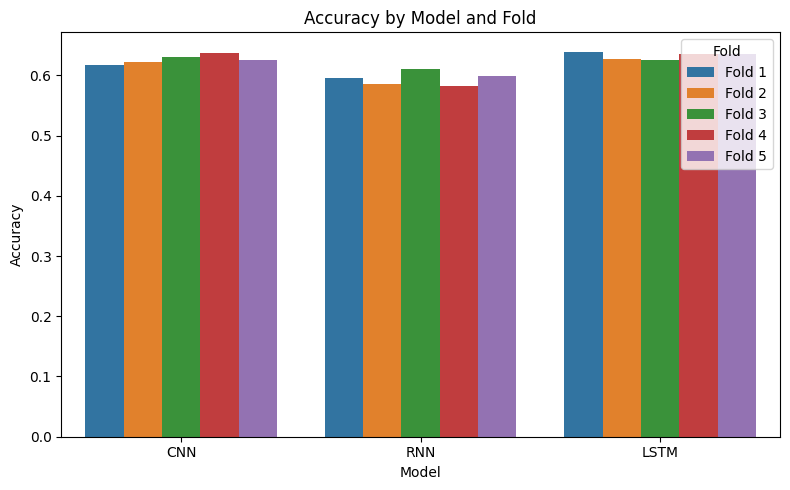

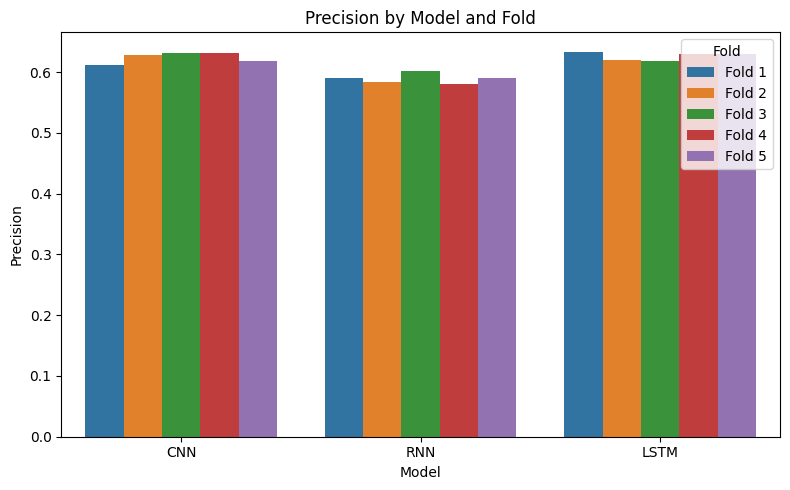

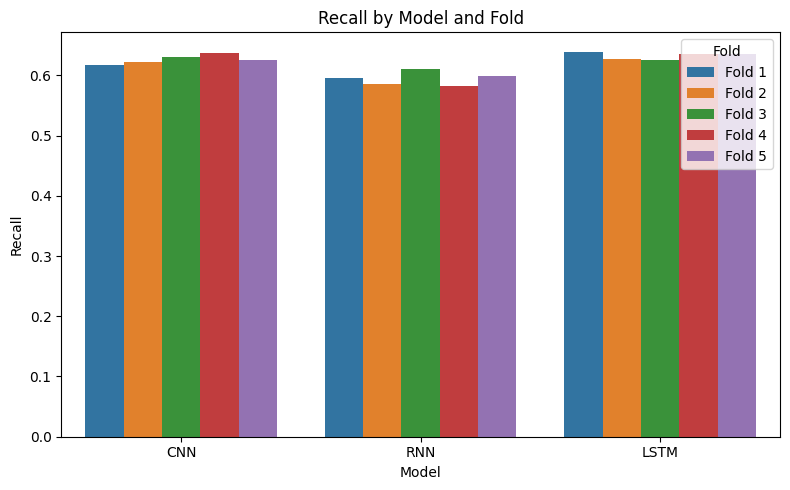

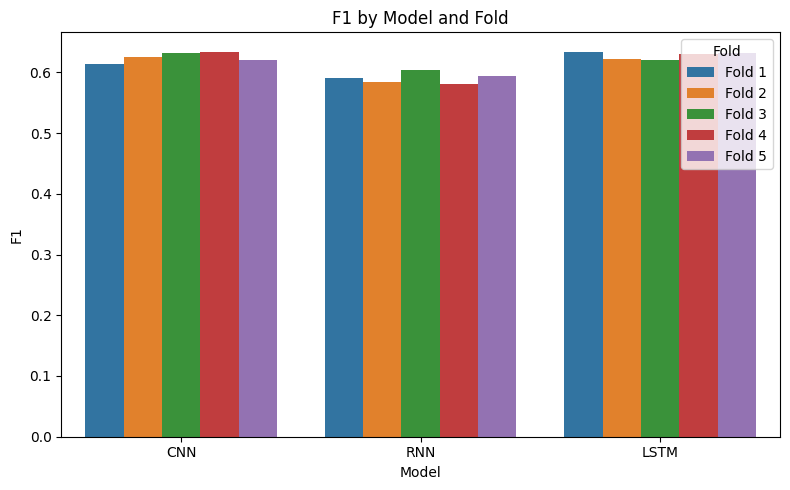

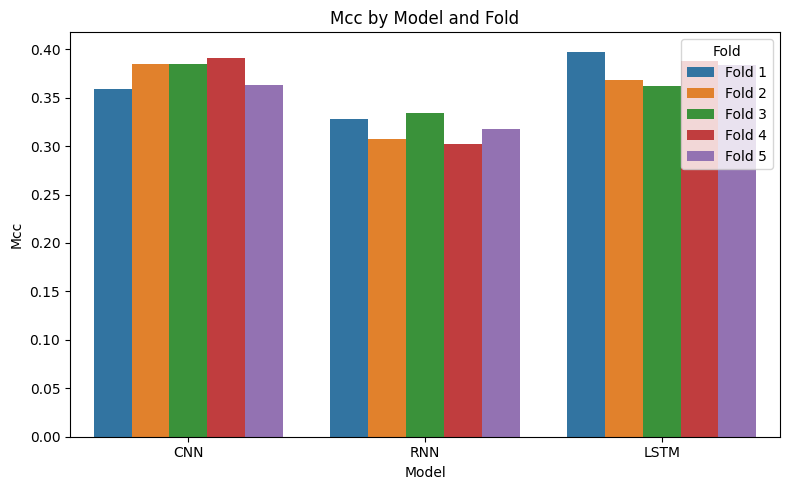

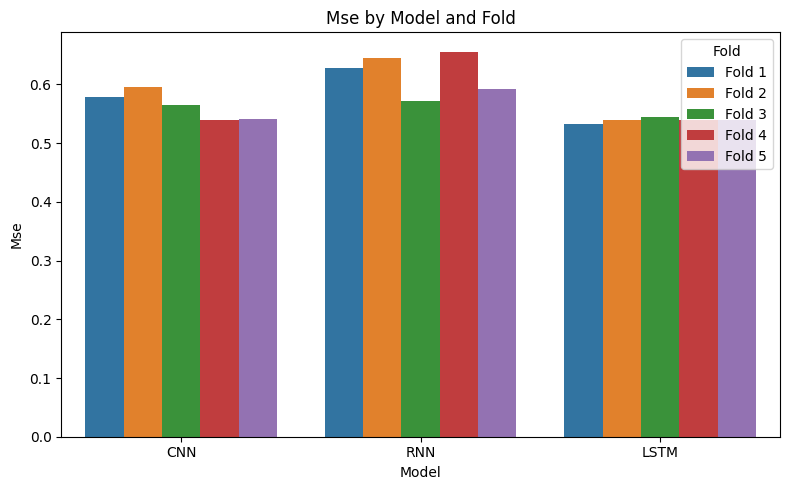

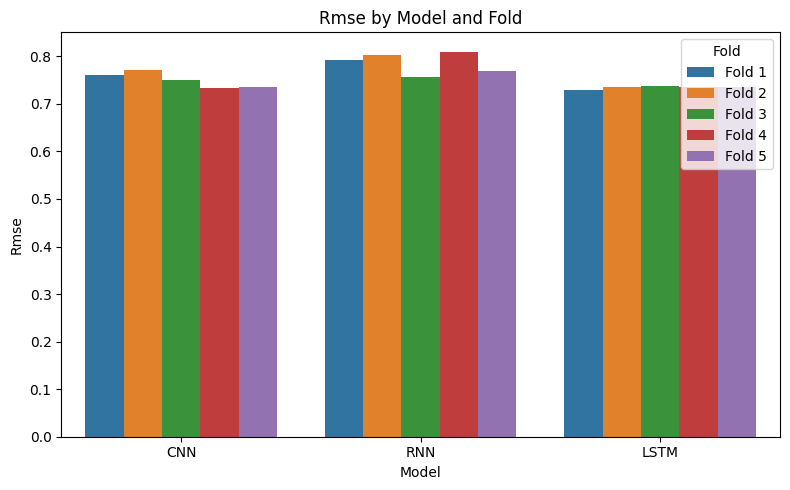

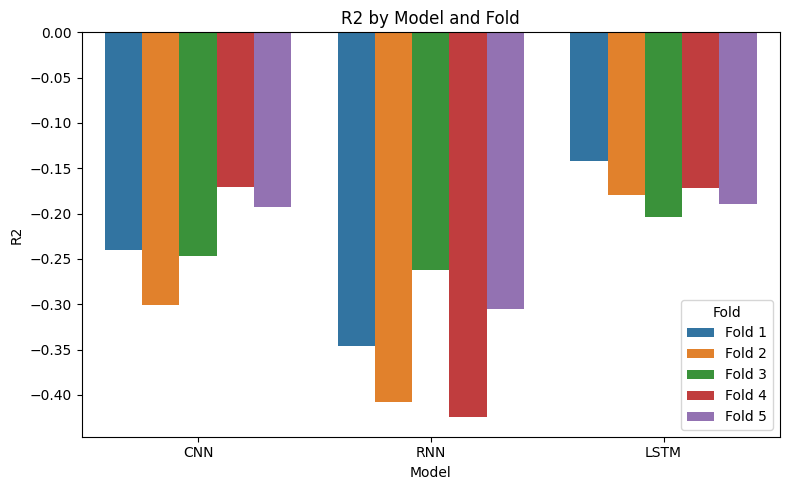

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

for metric in metrics_to_plot:
    plt.figure(figsize=(8, 5))
    sns.barplot(data=plot_df, x='Model', y=metric, hue='Fold')
    plt.title(f'{metric.capitalize()} by Model and Fold')
    plt.ylabel(metric.capitalize())
    plt.tight_layout()
    plt.show()